# Experiment Results Visualization

This notebook parses all experiment results from the `experiment_results` directory,
combines them into a CSV file, and visualizes them as heatmaps.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from cmap import Colormap

In [ ]:
# Load channel mapping from central config file
import json as _json
with open("channel_config.json", "r") as f:
    _config = _json.load(f)
    CHANNEL_MAPPING = _config["channel_mapping"]
    DIRECT_CHANNELS = _config["channel_groups"]["DIRECT"]
    INDIRECT_CHANNELS = _config["channel_groups"]["INDIRECT"]
    ALL_CHANNELS = _config["channel_groups"]["ALL"]

# Create index-to-name mapping (indices match the order in CHANNEL_MAPPING.keys())
CHANNEL_KEYS = list(CHANNEL_MAPPING.keys())

# Define canonical signal order based on channel_config.json
# Single channels first (in config order), then groups
SINGLE_CHANNEL_ORDER = [1, 2, 3, 4, 5, 7, 8, 9]  # Matches channel indices used in experiments
GROUP_ORDER = ["DIRECT", "INDIRECT", "ALL"]

def get_channel_name(channel_idx):
    """Get descriptive name for a channel index."""
    if 0 <= channel_idx < len(CHANNEL_KEYS):
        return CHANNEL_MAPPING[CHANNEL_KEYS[channel_idx]]
    return f"Channel {channel_idx}"

def get_channels_label(channel_indices):
    """Get a readable label for a list of channel indices."""
    # Check for predefined groups first
    if channel_indices == DIRECT_CHANNELS:
        return "All 3 Direct Channels"
    elif channel_indices == INDIRECT_CHANNELS:
        return "All 5 Indirect Channels"
    elif channel_indices == ALL_CHANNELS:
        return "All 8 Channels"
    
    # For single channel, return the descriptive name
    if len(channel_indices) == 1:
        return get_channel_name(channel_indices[0])
    
    # For multiple channels, return a descriptive label
    names = [get_channel_name(idx) for idx in channel_indices]
    if len(names) <= 3:
        return ', '.join(names)
    else:
        return f"{len(names)} channels: {', '.join(names[:2])}, ..."

def get_canonical_sort_key(channels_label, channels_list=None):
    """Get sort key for canonical ordering based on channel_config.json."""
    # Groups come after single channels
    if channels_label == "All 3 Direct Channels":
        return (1, GROUP_ORDER.index("DIRECT"))
    elif channels_label == "All 5 Indirect Channels":
        return (1, GROUP_ORDER.index("INDIRECT"))
    elif channels_label == "All 8 Channels":
        return (1, GROUP_ORDER.index("ALL"))
    
    # Single channels: sort by their position in SINGLE_CHANNEL_ORDER
    if channels_list is not None and len(channels_list) == 1:
        channel_idx = channels_list[0]
        if channel_idx in SINGLE_CHANNEL_ORDER:
            return (0, SINGLE_CHANNEL_ORDER.index(channel_idx))
    
    # Fallback: alphabetical
    return (2, channels_label)

In [36]:
# Set larger font sizes for presentations
sns.set_context('talk')

# Set colorblind-friendly Okabe-Ito palette globally
cm_mpl = Colormap('okabeito:okabeito').to_mpl()
okabe_ito_colors = [cm_mpl(i / 7) for i in range(8)]
sns.set_style('whitegrid')
sns.set_palette(okabe_ito_colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=okabe_ito_colors)
plt.rcParams['figure.dpi'] = 100

# Set serif font LAST to ensure it's not overwritten
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [37]:
def parse_test_results(file_path):
    """Parse a test_results.txt file and extract key information."""
    with open(file_path, 'r') as f:
        content = f.read()
    
    result = {}
    
    # Extract channels used
    channels_match = re.search(r'Channels Used: \[([\d, ]+)\]', content)
    if channels_match:
        channels_str = channels_match.group(1)
        result['channels'] = [int(x.strip()) for x in channels_str.split(',')]
        result['channels_str'] = ','.join(str(c) for c in result['channels'])
        result['n_channels'] = len(result['channels'])
        # Add readable channel names
        result['channels_readable'] = [get_channel_name(c) for c in result['channels']]
        result['channels_label'] = get_channels_label(result['channels'])
    
    # Extract classification target (stop at newline)
    target_match = re.search(r'Classification Target: ([^\n]+)', content)
    if target_match:
        result['classification_target'] = target_match.group(1).strip()
    
    # Extract metrics (handle spaces in metric names)
    # Pattern: metric_name (with possible spaces) : value
    metric_pattern = r'(test_[\w\s]+?)\s*:\s*([\d.]+)'
    for match in re.finditer(metric_pattern, content):
        metric_name = match.group(1).strip().replace(' ', '_')
        metric_value = float(match.group(2))
        result[metric_name] = metric_value
    
    return result

In [38]:
# Load all test results from experiment_results directory
results_dir = Path('experiment_results')
all_results = []

if not results_dir.exists():
    raise FileNotFoundError(f"Directory {results_dir} does not exist. Run experiments first!")

# Find all test_results.txt files
test_result_files = list(results_dir.glob('*/test_results.txt'))

print(f"Found {len(test_result_files)} experiment result files")

for result_file in sorted(test_result_files):
    try:
        result = parse_test_results(result_file)
        result['experiment_name'] = result_file.parent.name
        all_results.append(result)
    except Exception as e:
        print(f"Error parsing {result_file}: {e}")

print(f"Successfully parsed {len(all_results)} results")

Found 22 experiment result files
Successfully parsed 22 results


In [39]:
# Create DataFrame
df = pd.DataFrame(all_results)

# Sort by classification target and channels for better readability
df = df.sort_values(['classification_target', 'n_channels', 'channels_str']).reset_index(drop=True)

print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df


DataFrame shape: (22, 12)

Columns: ['channels', 'channels_str', 'n_channels', 'channels_readable', 'channels_label', 'classification_target', 'test_acc_Deep_Drawing', 'test_f1_Deep_Drawing', 'test_loss', 'experiment_name', 'test_acc_Ironing', 'test_f1_Ironing']

First few rows:


,channels,channels_str,n_channels,channels_readable,channels_label,classification_target,test_acc_Deep_Drawing,test_f1_Deep_Drawing,test_loss,experiment_name,test_acc_Ironing,test_f1_Ironing
0,[1],1,1,[Strip Connection Cut (Direct)],Strip Connection Cut (Direct),Deep Drawing,0.961111,0.961046,0.140673,signal_1_deepdrawing,NaN,NaN
1,[2],2,1,[Deep Drawing (Direct)],Deep Drawing (Direct),Deep Drawing,0.582222,0.490529,0.823748,signal_2_deepdrawing,NaN,NaN
2,[3],3,1,[Ironing (Direct)],Ironing (Direct),Deep Drawing,0.971111,0.971034,0.114778,signal_3_deepdrawing,NaN,NaN
3,[4],4,1,[Deep Drawing - Top (Indirect)],Deep Drawing - Top (Indirect),Deep Drawing,0.925556,0.924711,0.213729,signal_4_deepdrawing,NaN,NaN
4,[5],5,1,[Deep Drawing - Bottom (Indirect)],Deep Drawing - Bottom (Indirect),Deep Drawing,0.977778,0.977849,0.080152,signal_5_deepdrawing,NaN,NaN
5,[7],7,1,[Ironing - Top (Indirect)],Ironing - Top (Indirect),Deep Drawing,1.000000,1.000000,0.002828,signal_7_deepdrawing,NaN,NaN
6,[8],8,1,[Ironing - Stamp Holder (Indirect)],Ironing - Stamp Holder (Indirect),Deep Drawing,0.988889,0.988865,0.049529,signal_8_deepdrawing,NaN,NaN
7,[9],9,1,[Ironing - Bottom (Indirect)],Ironing - Bottom (Indirect),Deep Drawing,0.982222,0.982192,0.054833,signal_9_deepdrawing,NaN,NaN
8,"[1, 2, 3]","1,2,3",3,"[Strip Connection Cut (Direct), Deep Drawing (...",DIRECT (3 channels),Deep Drawing,0.728889,0.677272,0.579223,direct_deepdrawing,NaN,NaN
9,"[4, 5, 7, 8, 9]","4,5,7,8,9",5,"[Deep Drawing - Top (Indirect), Deep Drawing -...",INDIRECT (5 channels),Deep Drawing,0.977778,0.977708,0.065644,indirect_deepdrawing,NaN,NaN


In [40]:
# Save to CSV
csv_path = results_dir / 'all_results.csv'
df.to_csv(csv_path, index=False)
print(f"Saved combined results to {csv_path}")
print(f"CSV contains {len(df)} experiments")

Saved combined results to experiment_results/all_results.csv
CSV contains 22 experiments


In [41]:
# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nExperiments by Classification Target:")
print(df['classification_target'].value_counts())

print("\nExperiments by Number of Channels:")
print(df['n_channels'].value_counts().sort_index())

# Get F1 columns
f1_columns = [col for col in df.columns if col.startswith('test_f1_')]

if f1_columns:
    print("\nF1 Score Statistics:")
    for col in f1_columns:
        target = col.replace('test_f1_', '').replace('_', ' ').title()
        print(f"\n  {target}:")
        print(f"    Mean: {df[col].mean():.4f}")
        print(f"    Std:  {df[col].std():.4f}")
        print(f"    Min:  {df[col].min():.4f}")
        print(f"    Max:  {df[col].max():.4f}")


SUMMARY STATISTICS

Experiments by Classification Target:
classification_target
Deep Drawing    11
Ironing         11
Name: count, dtype: int64

Experiments by Number of Channels:
n_channels
1    16
3     2
5     2
8     2
Name: count, dtype: int64

F1 Score Statistics:

  Deep Drawing:
    Mean: 0.9039
    Std:  0.1648
    Min:  0.4905
    Max:  1.0000

  Ironing:
    Mean: 0.8466
    Std:  0.2435
    Min:  0.1679
    Max:  0.9967


In [42]:
# Prepare data for heatmap visualization
# We'll create separate heatmaps for each classification target

def create_heatmap_data(df, target_col):
    """Create a pivot table for heatmap visualization."""
    # Filter for experiments that have this target
    target_name = target_col.replace('test_f1_', '').replace('_', ' ')
    df_target = df[df[target_col].notna()].copy()
    
    if len(df_target) == 0:
        return None, None
    
    # Create a readable label for channel configuration
    df_target['channel_label'] = df_target.apply(
        lambda row: f"{row['n_channels']}ch: [{row['channels_str']}]", 
        axis=1
    )
    
    # Create pivot table
    pivot = df_target.pivot_table(
        values=target_col,
        index='channel_label',
        columns='classification_target',
        aggfunc='mean'
    )
    
    return pivot, target_name

# Get all F1 score columns
f1_columns = [col for col in df.columns if col.startswith('test_f1_')]
print(f"Found F1 columns: {f1_columns}")

Found F1 columns: ['test_f1_Deep_Drawing', 'test_f1_Ironing']


Saved heatmap to experiment_results/f1_scores_heatmap.pdf


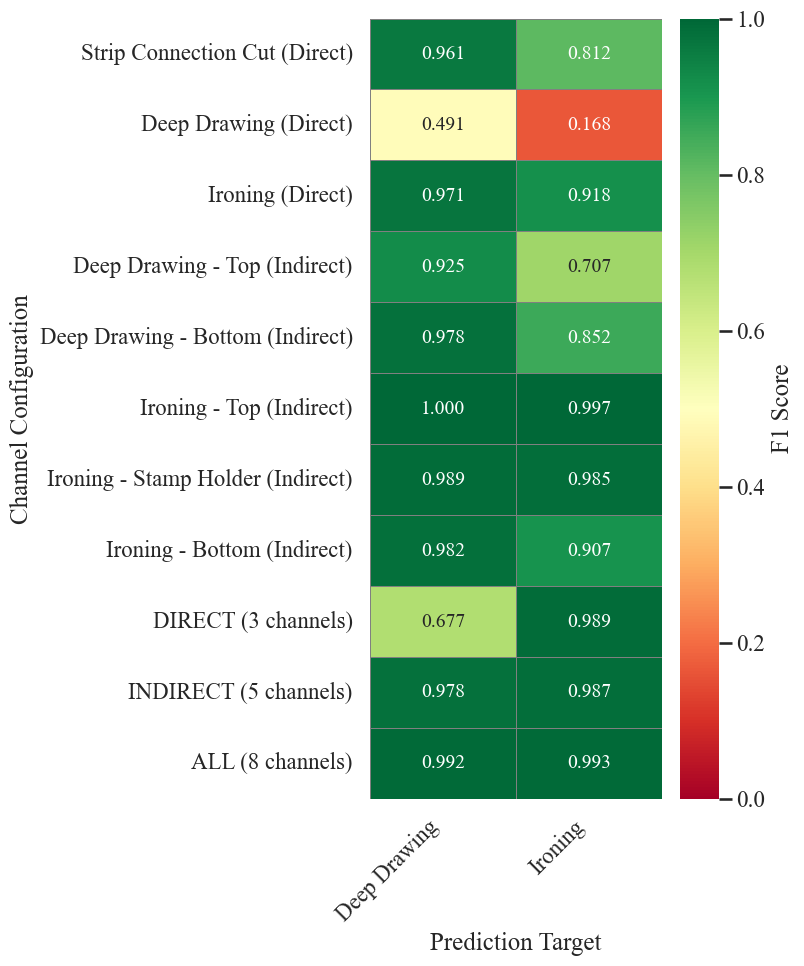

In [43]:
# Create a combined heatmap showing all targets
# Rows: Channel configurations, Columns: Classification targets, Values: F1 scores

# Use the readable channel labels that were created during parsing
# Note: channels_label was already created in parse_test_results using get_channels_label()

# Melt the dataframe to long format for all F1 scores
f1_cols = [col for col in df.columns if col.startswith('test_f1_')]
df_long = df.melt(
    id_vars=['experiment_name', 'channels_label', 'channels_str', 'channels', 'n_channels', 'classification_target'],
    value_vars=f1_cols,
    var_name='metric',
    value_name='f1_score'
)

# Remove rows with NaN F1 scores
df_long = df_long[df_long['f1_score'].notna()]

# Extract the target from the metric name
df_long['target_from_metric'] = df_long['metric'].str.replace('test_f1_', '').str.replace('_', ' ')

# Create a combined label showing what was predicted
df_long['prediction_label'] = df_long.apply(
    lambda row: f"{row['target_from_metric']}",
    axis=1
)

# Create pivot table for the main heatmap
pivot_main = df_long.pivot_table(
    values='f1_score',
    index='channels_label',
    columns='prediction_label',
    aggfunc='mean'
)

# Sort using canonical order from channel_config.json
# Build mapping from label to channels list for sorting (handle unhashable lists)
label_to_channels = {}
for _, row in df[['channels_label', 'channels']].iterrows():
    label_to_channels[row['channels_label']] = row['channels']

# Create sorting keys using canonical order
sort_keys = [(get_canonical_sort_key(idx, label_to_channels.get(idx)), idx) for idx in pivot_main.index]
sorted_indices = [x[1] for x in sorted(sort_keys)]
pivot_main = pivot_main.loc[sorted_indices]

# Plot the combined heatmap
fig, ax = plt.subplots(figsize=(max(8, len(pivot_main.columns) * 1.5), max(10, len(pivot_main) * 0.5)))

sns.heatmap(
    pivot_main,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'F1 Score'},
    ax=ax,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'fontsize': 14}
)

ax.set_xlabel('Prediction Target')
ax.set_ylabel('Channel Configuration')

# Rotate labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(results_dir / 'f1_scores_heatmap.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig(results_dir / 'f1_scores_heatmap.png', bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved heatmap to {results_dir / 'f1_scores_heatmap.pdf'}")
plt.show()

Saved Deep Drawing heatmap to experiment_results/deep_drawing_f1_heatmap.pdf


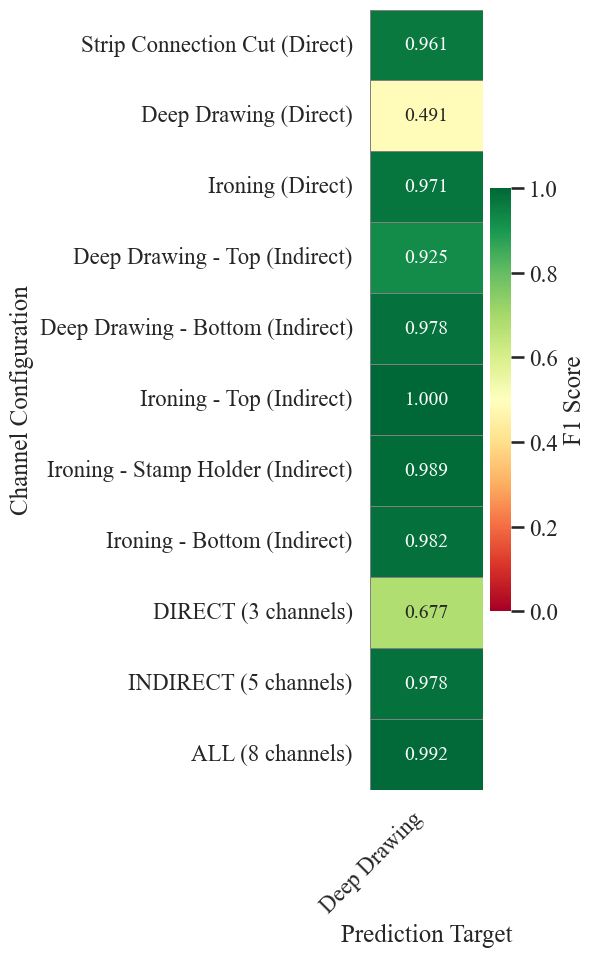

Saved Ironing heatmap to experiment_results/ironing_f1_heatmap.pdf


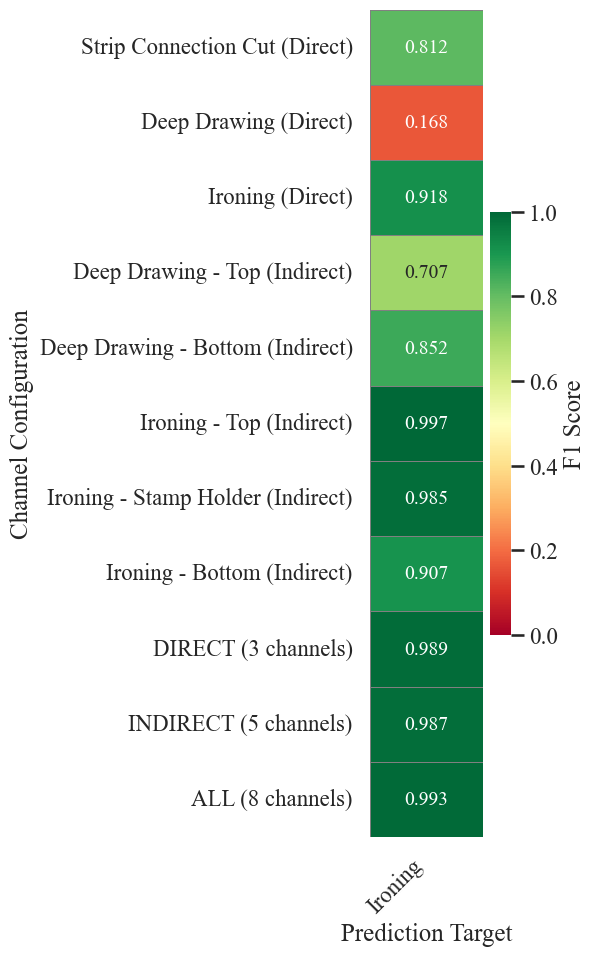

In [44]:
# Create separate detailed heatmaps for Deep Drawing and Ironing
# This will show: Rows = Channel configs, Columns = Classification target used

for f1_col in f1_cols:
    target_name = f1_col.replace('test_f1_', '').replace('_', ' ').title()
    
    # Filter for experiments with this F1 score
    df_filtered = df[df[f1_col].notna()].copy()
    
    if len(df_filtered) == 0:
        continue
    
    # Create pivot: Rows = channel configs, Columns = classification target
    pivot = df_filtered.pivot_table(
        values=f1_col,
        index='channels_label',
        columns='classification_target',
        aggfunc='mean'
    )
    
    # Sort using canonical order from channel_config.json
    # Build mapping from label to channels list (handle unhashable lists)
    label_to_channels = {}
    for _, row in df_filtered[['channels_label', 'channels']].iterrows():
        label_to_channels[row['channels_label']] = row['channels']
    
    sort_keys = [(get_canonical_sort_key(idx, label_to_channels.get(idx)), idx) for idx in pivot.index]
    sorted_indices = [x[1] for x in sorted(sort_keys)]
    pivot = pivot.loc[sorted_indices]
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(6, len(pivot.columns) * 2), max(10, len(pivot) * 0.5)))
    
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'F1 Score'},
        ax=ax,
        linewidths=0.5,
        linecolor='gray',
        annot_kws={'fontsize': 14}
    )
    
    ax.set_xlabel('Prediction Target')
    ax.set_ylabel('Channel Configuration')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    filename = f"{target_name.lower().replace(' ', '_')}_f1_heatmap"
    plt.savefig(results_dir / f'{filename}.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.savefig(results_dir / f'{filename}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    print(f"Saved {target_name} heatmap to {results_dir / filename}.pdf")
    plt.show()

In [45]:
# Find top performing configurations for each target
print("\n" + "="*80)
print("TOP PERFORMING CONFIGURATIONS")
print("="*80)

for f1_col in f1_cols:
    target_name = f1_col.replace('test_f1_', '').replace('_', ' ').title()
    
    df_sorted = df[df[f1_col].notna()].sort_values(f1_col, ascending=False)
    
    print(f"\n{target_name} - Top 5 Configurations:")
    print("-" * 80)
    
    for idx, row in df_sorted.head(5).iterrows():
        print(f"  {row[f1_col]:.4f} - {row['channels_label']} - Target: {row['classification_target']}")
    
    print(f"\n{target_name} - Bottom 5 Configurations:")
    print("-" * 80)
    
    for idx, row in df_sorted.tail(5).iterrows():
        print(f"  {row[f1_col]:.4f} - {row['channels_label']} - Target: {row['classification_target']}")


TOP PERFORMING CONFIGURATIONS

Deep Drawing - Top 5 Configurations:
--------------------------------------------------------------------------------
  1.0000 - Ironing - Top (Indirect) - Target: Deep Drawing
  0.9922 - ALL (8 channels) - Target: Deep Drawing
  0.9889 - Ironing - Stamp Holder (Indirect) - Target: Deep Drawing
  0.9822 - Ironing - Bottom (Indirect) - Target: Deep Drawing
  0.9778 - Deep Drawing - Bottom (Indirect) - Target: Deep Drawing

Deep Drawing - Bottom 5 Configurations:
--------------------------------------------------------------------------------
  0.9710 - Ironing (Direct) - Target: Deep Drawing
  0.9610 - Strip Connection Cut (Direct) - Target: Deep Drawing
  0.9247 - Deep Drawing - Top (Indirect) - Target: Deep Drawing
  0.6773 - DIRECT (3 channels) - Target: Deep Drawing
  0.4905 - Deep Drawing (Direct) - Target: Deep Drawing

Ironing - Top 5 Configurations:
--------------------------------------------------------------------------------
  0.9967 - Ironing

In [46]:
# Analyze single-channel performance to understand channel importance
print("\n" + "="*80)
print("SINGLE CHANNEL PERFORMANCE ANALYSIS")
print("="*80)

df_single = df[df['n_channels'] == 1].copy()

if len(df_single) > 0:
    # Extract single channel number
    df_single['channel_num'] = df_single['channels'].apply(lambda x: x[0] if len(x) == 1 else None)
    df_single['channel_name'] = df_single['channel_num'].apply(get_channel_name)
    
    for f1_col in f1_cols:
        target_name = f1_col.replace('test_f1_', '').replace('_', ' ').title()
        
        df_target = df_single[df_single[f1_col].notna()].copy()
        
        if len(df_target) == 0:
            continue
        
        print(f"\n{target_name}:")
        print("-" * 80)
        
        # Group by channel name for better readability
        channel_performance = df_target.groupby('channel_name')[f1_col].mean().sort_values(ascending=False)
        
        for channel_name, score in channel_performance.items():
            print(f"  {channel_name}: {score:.4f}")
else:
    print("No single-channel experiments found.")


SINGLE CHANNEL PERFORMANCE ANALYSIS

Deep Drawing:
--------------------------------------------------------------------------------
  Ironing - Top (Indirect): 1.0000
  Ironing - Stamp Holder (Indirect): 0.9889
  Ironing - Bottom (Indirect): 0.9822
  Deep Drawing - Bottom (Indirect): 0.9778
  Ironing (Direct): 0.9710
  Strip Connection Cut (Direct): 0.9610
  Deep Drawing - Top (Indirect): 0.9247
  Deep Drawing (Direct): 0.4905

Ironing:
--------------------------------------------------------------------------------
  Ironing - Top (Indirect): 0.9967
  Ironing - Stamp Holder (Indirect): 0.9845
  Ironing (Direct): 0.9179
  Ironing - Bottom (Indirect): 0.9066
  Deep Drawing - Bottom (Indirect): 0.8516
  Strip Connection Cut (Direct): 0.8115
  Deep Drawing - Top (Indirect): 0.7074
  Deep Drawing (Direct): 0.1679


Saved accuracy vs F1 plot to experiment_results/accuracy_vs_f1.pdf


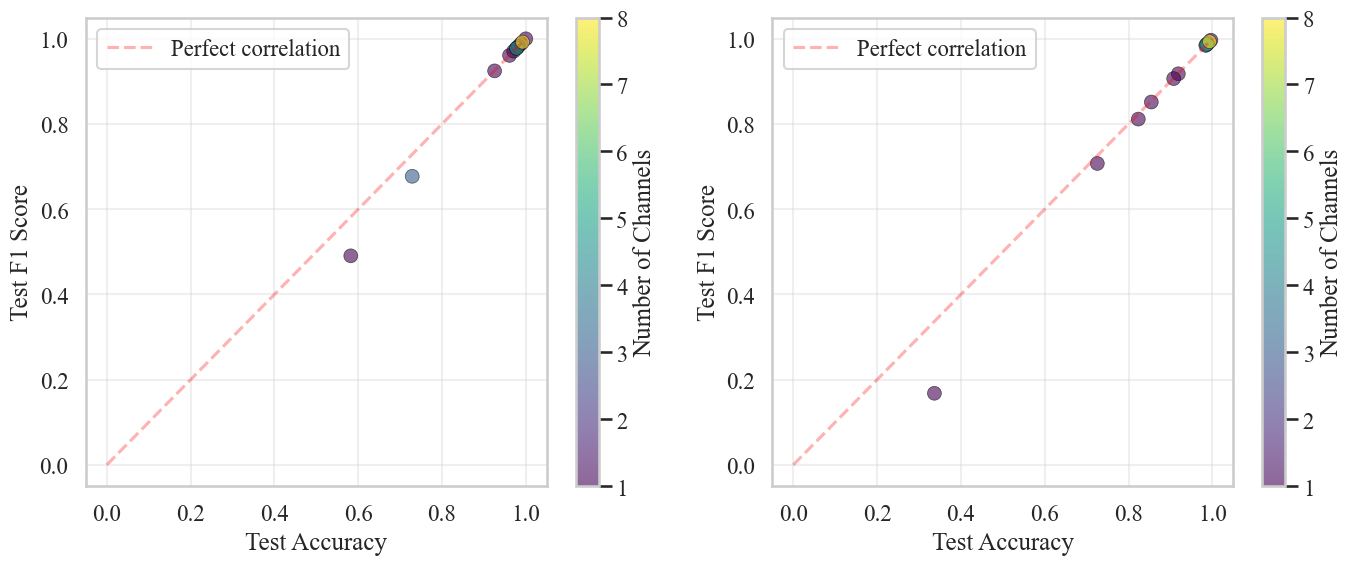

In [47]:
# Plot accuracy vs F1 score to see if there are any anomalies
fig, axes = plt.subplots(1, len(f1_cols), figsize=(7 * len(f1_cols), 6))

if len(f1_cols) == 1:
    axes = [axes]

for ax, f1_col in zip(axes, f1_cols):
    target_name = f1_col.replace('test_f1_', '').replace('_', ' ').title()
    acc_col = f1_col.replace('f1', 'acc')
    
    if acc_col not in df.columns:
        continue
    
    df_plot = df[[f1_col, acc_col, 'n_channels']].dropna()
    
    scatter = ax.scatter(
        df_plot[acc_col], 
        df_plot[f1_col],
        c=df_plot['n_channels'],
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Perfect correlation')
    
    ax.set_xlabel('Test Accuracy')
    ax.set_ylabel('Test F1 Score')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Channels')

plt.tight_layout()
plt.savefig(results_dir / 'accuracy_vs_f1.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig(results_dir / 'accuracy_vs_f1.png', bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved accuracy vs F1 plot to {results_dir / 'accuracy_vs_f1.pdf'}")
plt.show()